<a href="https://colab.research.google.com/github/mterion/tensorflow-1-public/blob/main/C4/W2/ungraded_labs/C4_W2_Lab_2_single_layer_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [2]:
#!pip install tensorflow==2.5.0

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.7.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [20]:
# Refs https://www.tensorflow.org/api_docs/python/tf/data/Dataset#flat_map

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series) # Creates a Dataset whose elements are slices of the given tensors.
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True) # Each "window" is a dataset that contains a subset of elements of the input dataset. Keep all the same size with drop_remainder = True, if lenght at then end is shorter
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1)) # Use flat_map if you want to make sure that the order of your dataset stays the same. For example, to flatten a dataset of batches into a dataset of their elements
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1) # Most dataset input pipelines should end with a call to prefetch. This allows later elements to be prepared while the current element is being processed.
  return dataset

In [21]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size) # windowed_dataset on x_train
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(dataset,epochs=100,verbose=0)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>
Layer weights [array([[ 0.00458447],
       [-0.01825968],
       [ 0.02681567],
       [-0.07840343],
       [ 0.0935439 ],
       [-0.02498079],
       [-0.03603967],
       [ 0.02574194],
       [-0.01326795],
       [ 0.02749361],
       [ 0.01447782],
       [ 0.00118212],
       [-0.0855547 ],
       [ 0.06722384],
       [ 0.04581417],
       [-0.001137  ],
       [ 0.05988524],
       [ 0.18443488],
       [ 0.21307564],
       [ 0.4869188 ]], dtype=float32), array([0.01237157], dtype=float32)]


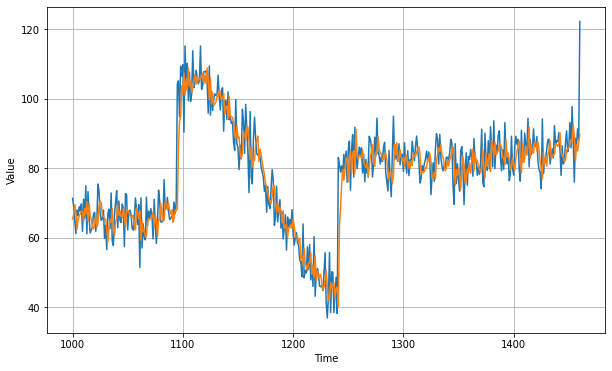

In [24]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [25]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
  # Might see different results when you switch notebook
  ## Series has a random element with noise, then noise might change from one to another

4.9311557